In [ ]:
!pip install rasterio
!pip install scipy

In [ ]:
from rasterio.plot import show
from scipy.interpolate import griddata
from rasterio.transform import Affine

import rasterio
import numpy as np

Importar fuente

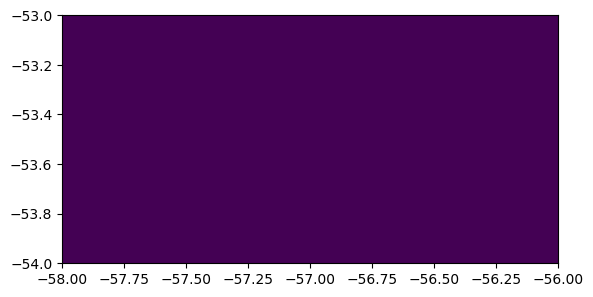

BoundingBox(left=-58.0, bottom=-54.0, right=-56.0, top=-53.0)

In [ ]:
src = rasterio.open("S54W058_D001_S001_T001_L00_U0_R0.tif")
show(src)
src.bounds

In [ ]:
band1 = src.read(1)

grid_x, grid_y = np.mgrid[-58:-56:512j, -55:-54:512j]

points_x = np.linspace(-58, -56, num=1024, endpoint=True)
points_y = np.linspace(-55, -54, num=1024, endpoint=True)

points = []
values = []

for y in range(1024):
  for x in range(1024):
    points.append((points_x[x], points_y[y]))
    values.append(band1[x][y])

grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

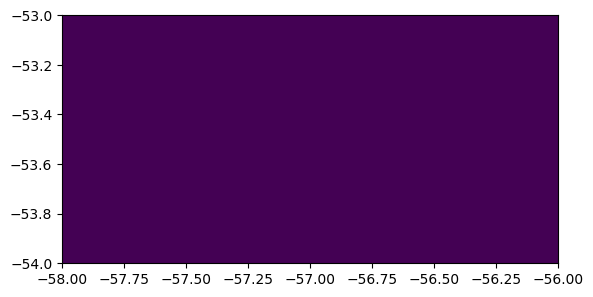

BoundingBox(left=-58.0, bottom=-54.0, right=-56.0, top=-53.0)

In [ ]:
file_name = "S54W058_D001_S001_T001_LC01_U0_R0.tif"
tforigin = None
tfnew = None

with rasterio.Env():
    size = len(grid_z1)
    profile = src.profile
    profile['height'] = size
    profile['width'] = size
    tforigin = profile['transform']
    tfnew = Affine(2/size, 0.0, -58.0, 0.0, -1/size, -53.0)
    profile['transform'] = tfnew

    with rasterio.open(file_name, 'w', **profile) as dst:
        dst.write(grid_z1.astype(rasterio.float64), 1)

src = rasterio.open(file_name)
show(src)
src.bounds

In [ ]:
len(src.read(1))

512

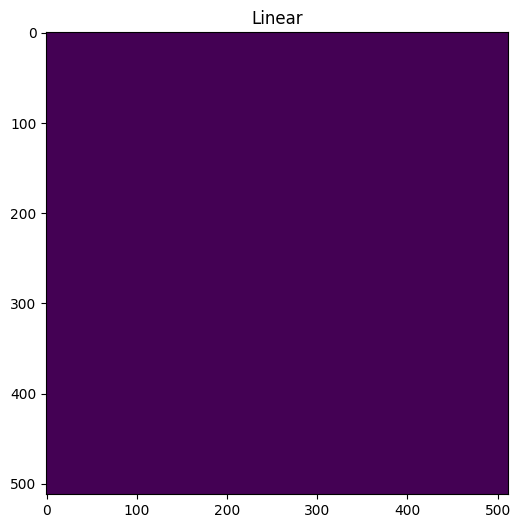

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(grid_z1)
plt.title('Linear')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [ ]:
# @title
def update_points(lon, lat, list):
  index_lon = 0
  index_lat = 0

  while (list[0][index_lon][0] < lon):
    index_lon += 1

  while (list[index_lat][0][1] > lat):
    index_lat += 1

  if (index_lat == len(list)):
    index_lat = index_lat - 1
  if (index_lon == len(list[0])):
    index_lon = index_lon - 1

  if (index_lat == 0):
    index_lat = index_lat + 1
  if (index_lon == 0):
    index_lon = index_lon + 1

  return [(list[index_lat-1][index_lon-1]),
         (list[index_lat-1][index_lon]),
         (list[index_lat][index_lon-1]),
         (list[index_lat][index_lon]),
    ]

def binterpolation(x, y, points):
    pts = sorted(points)
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = pts
    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        print('The given points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        print('The (x, y) coordinates are not within the rectangle')
    P = (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)
    return P

def init_list(initial_list, left, bottom, right, top):
  latitud_len = len(initial_list)
  longitud_len = len(initial_list[0])

  lat_resolution = (top - bottom) / (latitud_len - 1)
  long_resulution = (right - left) / (longitud_len - 1)

  result = []
  for i in range(0, latitud_len):
    tmp_lat = []
    for j in range(0, longitud_len):
      tmp_lat.append((
            top - lat_resolution*i,
            left + long_resulution*j,
            initial_list[i][j],
      ))
    result.append(tmp_lat)

  return result

def generate_LOD00(data, left, bottom, right, top):
  original_info = init_list(data, left, bottom, right, top)

  lon_size = (right - left)
  lat_size = top - bottom

  row = int(lat_size * 1024)
  col = int((lon_size/2) * 1024) # Se dividido por 2 ya que estamos en latitudes de mas de 50°

  res_lon = lon_size/(col-1)
  res_lat = lat_size/(row-1)

  print(f'left{left}, bottom{bottom}, right{right}, top{top}')

  result = np.ndarray(shape=(row,col), dtype=float)

  for i in range(0,row):
    lat = top - i*res_lat
    for j in range(0,col):
      lon = left + j*res_lon
      points = update_points(lon, lat, original_info)
      result[i][j] = binterpolation(lon, lat, points)

  return result